<a href="https://colab.research.google.com/drive/1GH_h7TFmZJGZTtUreTLb2JSvGj6D50pd?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outline

This tutorial will demonstrate the application of soundscape_IR in detecting sika deer (*Cervus nippon*) calls from tropical forest recordings and learning their spectral variations. Please contact Yi-Jen Sun (elainesun442@gmail.com) or Tzu-Hao Harry Lin (schonkopf@gmail.com) for questions or suggestions.

<img src="https://raw.githubusercontent.com/yijensun/soundscape_IR/master/docs/images/workflow_case1_v5.png" width="900"/>

This tutorial contains four sections:
1. Preparation of a training spectrogram
  - Concatenation
2. Weekly-supervised model training
  - Periodicity-coded nonnegative matrix factorization (PC-NMF)
3. Target detection
  - Model prediction using adapative and semi-supervised learning
  - Spectrogram reconstrunction and occurrence detection
4. Feature learning
  - Extracting call-specific spectral variation using adaptive learning

# Installation

In [ ]:
# Clone soundscape_IR from GitHub @schonkopf
!git clone https://github.com/meil-brcas-org/soundscape_IR.git

# Install required packages
%cd soundscape_IR
%pip install -r requirements.txt

# 1. Training spectrogram

In the beginning, use the function ```audio_visualization``` to generate a spectrogram of sika deer calls. Most sika deer calls were recorded in frequencies below 4 kHz. In addition to sika deer calls, this audio also recorded many insect calls (> 3.5 kHz).

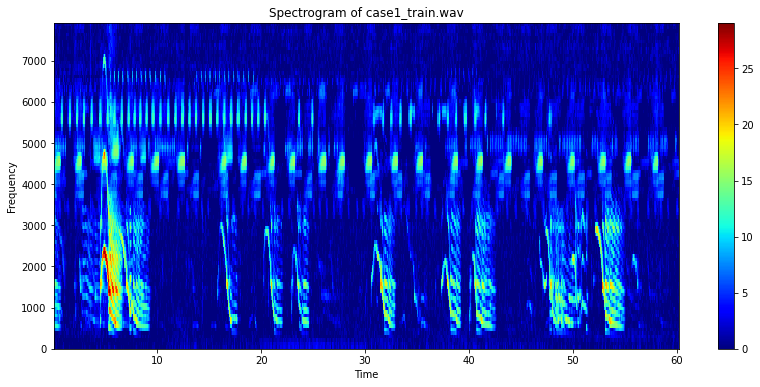

In [1]:
from soundscape_IR.soundscape_viewer import audio_visualization
# Generate a spectrogram, using 25 perentile (for each frequency bin) as the noise baseline to prewhiten the spectrogram
sound_train=audio_visualization(filename='case1_train.wav', path='./data/wav', FFT_size=512, time_resolution=0.1, window_overlap=0.5, plot_type='Spectrogram', prewhiten_percent=25, f_range=[0,8000])

## Concatenation
Based on the ```audio_visualization```, we can import a txt file contains manual annotations (generated by using [Raven software](https://ravensoundsoftware.com/) of Cornell Lab of Ornithology) to produce a concatenated spectrogram of deer calls. The concatenated spectrogram can reduce the amount of noise displayed in the training spectrogram and enhance the occuring periodicity of deer calls for training a source separation model in a weakly-supervised manner.


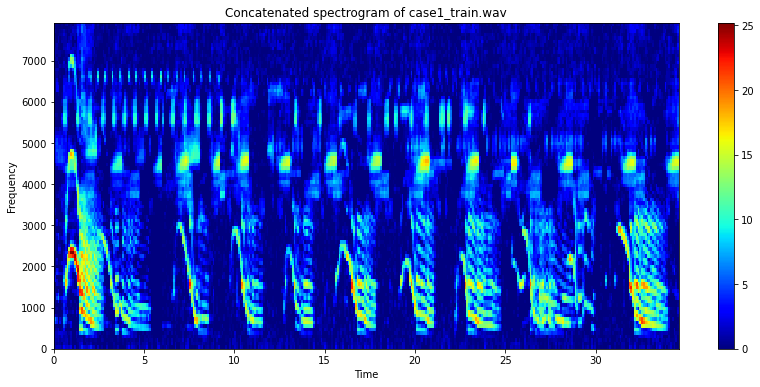

In [2]:
# Generate a spectrogram
sound_train=audio_visualization(filename='case1_train.wav', path='./data/wav', FFT_size=512, time_resolution=0.1, window_overlap=0.5, plot_type='Spectrogram', prewhiten_percent=25, f_range=[0,8000], annotation='./data/txt/case1_anno.txt', padding=0.5)

# 2. Model training

## PC-NMF
PC-NMF is a machine learning-based source separation model (Lin et al. 2017). It learns a set of basis functions essential for reconstructing the input spectrogram and separates the basis functions into groups according to their specific periodicity. In the function ```source_separation```, we use PC-NMF to learn two groups of basis functions for separating deer calls and noise.

After model training, we can visualize the two groups of basis functions and their source numbers (*source=1 or 2*). If the procedure of weakly-supervised learning works well, the model can be saved for further applications.

*   Tzu-Hao Lin, Shih-Hua Fang, Yu Tsao. (2017) Improving biodiversity assessment via unsupervised separation of biological sounds from long-duration recordings. Scientific Reports, 7: 4547. https://doi.org/10.1038/s41598-017-04790-7


C:\Users\user\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\soundscape_IR\soundscape_viewer\source_separation.py:111: RuntimeWarning: invalid value encountered in true_divide
  mask=np.divide(source,source0)


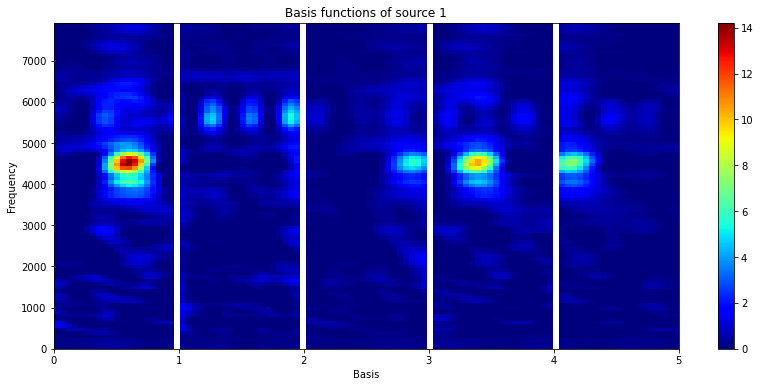

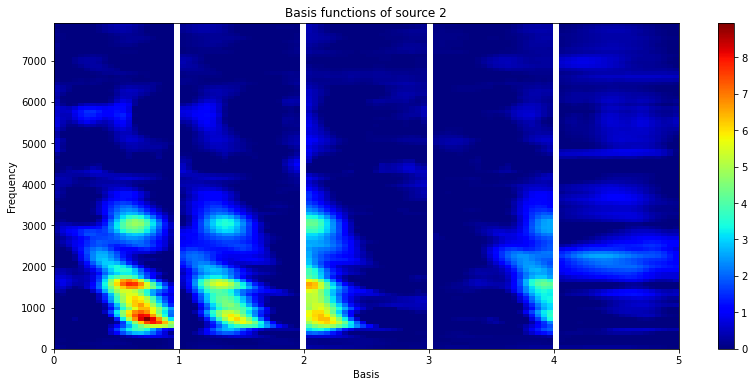

In [3]:
from soundscape_IR.soundscape_viewer import source_separation

# Define NMF parameters and train the model
model=source_separation(feature_length=20, basis_num=10)
model.learn_feature(input_data=sound_train.data, f=sound_train.f, method='PCNMF')

# Plot the basis functions of each source
model.plot_nmf(plot_type='W', source=1)
model.plot_nmf(plot_type='W', source=2)

# Save the model
model.save_model(filename='./data/model/case1_model.mat')

# 3. Target detection


Let us load another audio for testing the source separation model. Again, use audio_visualization to generate a spectrogram.

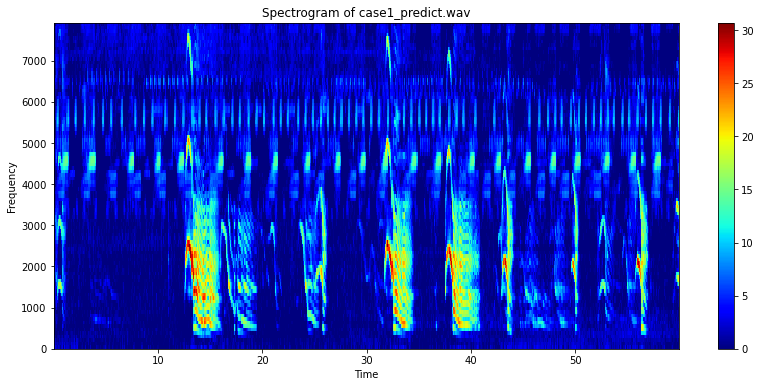

In [9]:
# Generate a spectrogram
sound_predict=audio_visualization(filename='case1_predict.wav', path='./data/wav', FFT_size=512, time_resolution=0.1, window_overlap=0.5, plot_type='Spectrogram', prewhiten_percent=25, f_range=[0,8000])

## Model prediction
Load the model by using ```source_separation```. Run model prediction with adaptive (*adaptive_alpha*) and semi-supervised (*additional_basis*) learning. After prediction, plot the basis functions to see how they adapt to the new spectrogram. With semi-supervised learning, the model also learns a new set of basis functions associated with unseen sound sources (*source=3*).

Model parameters check
Minima and maxima frequancy bin: 0.0 Hz and 7924.21875 Hz
Frequancy resolution: 86.1328125 Hz
Feature length: 20
Number of basis: 10
Number of source: 2


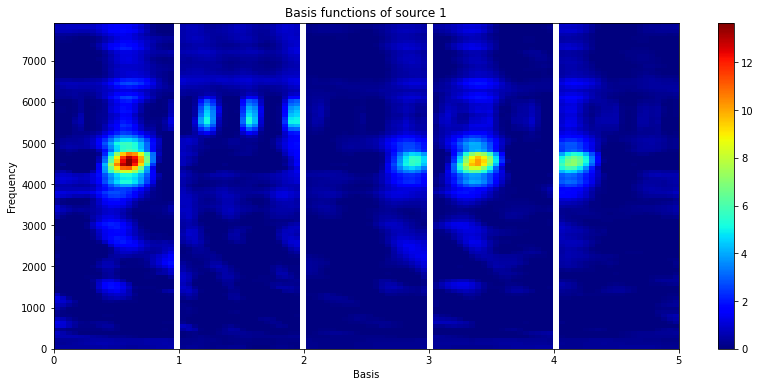

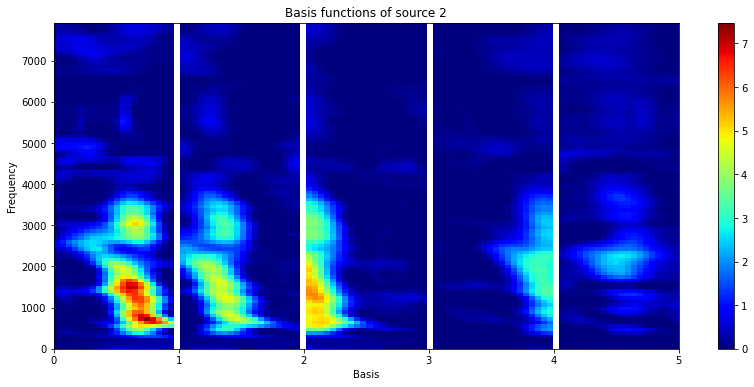

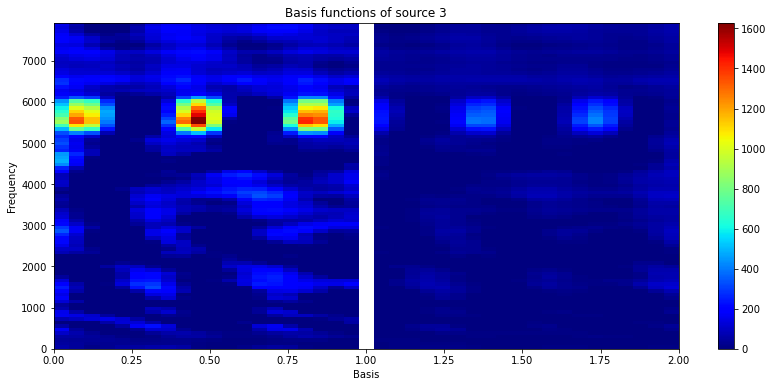

In [10]:
# Load the model and run prediction with adaptive and semi-supervised separation
model=source_separation()
model.load_model(filename = './data/model/case1_model.mat')
model.prediction(input_data=sound_predict.data, f=sound_predict.f, adaptive_alpha = [0.05,0.05], additional_basis = 2)

# Plot the adapted and newly learned features
for i in range(1, model.source_num+1):
 model.plot_nmf(plot_type='W', source=i)

## Spectrogram reconstruction and detection
After the prediction procedure, the reconstructed spectrogram of deer calls is saved in ```model.separation```. The reconstructed spectrogram is no longer interfered by noise. A simple energy detector can help identify the occurrence of deer calls. Use the function ```spectrogram_detection``` to process the reconstructed spectrogram for visualizing the detection result. Save the detection result in txt format and use Raven to explore.

Successifully save to sika_case1_detection.txt


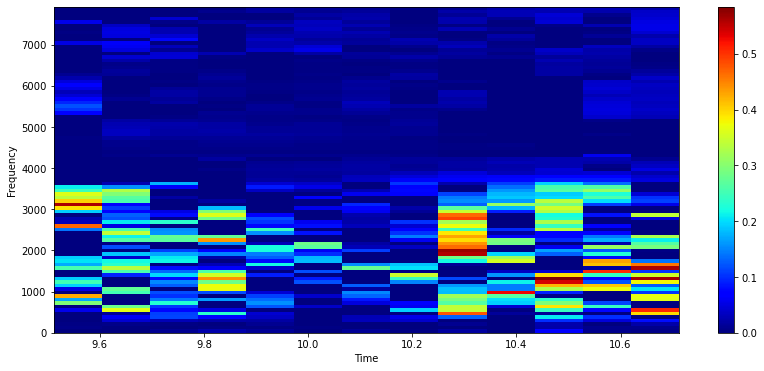

In [8]:
from soundscape_IR.soundscape_viewer import spectrogram_detection

# Detect the occurrence of target signals
source_num=2
sp=spectrogram_detection(input=model.separation[source_num-1], f=model.f, threshold=4.5, smooth=1, minimum_interval=0.5, pad_size=0, filename='sika_case1_detection.txt', path='./')

# 4. Feature learning

## Extracting call-specific spectral variation
In the final section, we will demonstrate the use of adaptive learning in extracting call-specific spectral variation. At first, select one deer call from the detection result and generate its spectrogram. Then, run model prediction but this time use a higher alpha value for the basis functions of deer calls to learn the spectral variation specific to the detected deer call. The result is a set of adapted basis functions (generally displaying different phases), we can select one adapted basis function to represent the selected deer call.

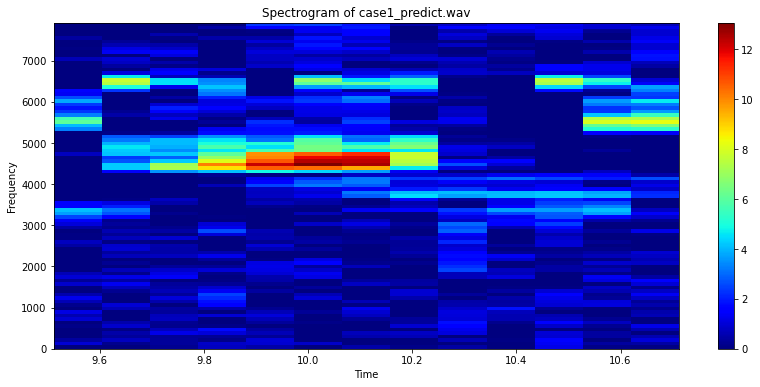

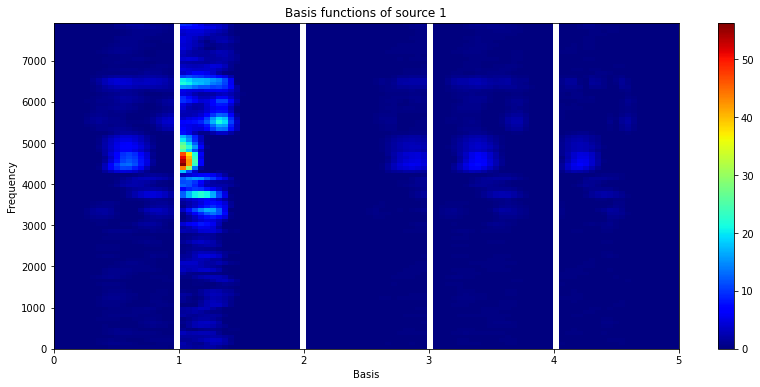

In [7]:
# Assign which call to extract
call_num=4
offset=float(sp.output[call_num][3]) # beginning time of the detected call
duration=float(sp.output[call_num][4]) - float(sp.output[call_num][3]) # duration of the detected call

# Generate a spectrogram
sound_call=audio_visualization(filename='case1_predict.wav', path='./data/wav', FFT_size=512, offset_read=offset, duration_read=duration, time_resolution=0.1, window_overlap=0.5, plot_type='Spectrogram', prewhiten_percent=25, f_range=[0,8000])

# Deploy the model with adaptive NMF
model.prediction(input_data=sound_call.data, f=sound_call.f, adaptive_alpha=[0.2,0,0])

# Plot the adapted features
model.plot_nmf(plot_type='W', source=source_num)